
# Data simulation
Here we illustrate the use of droplasso on simulated data, and compare it to standard dropout and elastic net regularisation. We design a toy simulation to illustrate in particular how corruption by dropout noise impacts the performances of the different methods. The simulation goes as follow : 

- We set the dimension to $d=20$.
- Each sample is a random vector $z\in\mathbb{N}^d$ with entries following a Poisson distribution with parameter $\pi=1$. The data variables are independent. 
- The "true" model is a logistic model with sparse weight vector $w\in\mathbb{R}^d$ with satisfying $w_i=+10, i=1 \ldots d_1 $, $w_i=-10  , i=(d_1+1) \ldots 2d_1$,  and $w_i=0$ for $i=(2d_1+1),\ldots,d.$ . 

$d_1$ here is fixed to 2 and thus we have 4 active predictors (with signal) in this simulation.   
- Using $w$ as the true underlying model and $z$ as the true observations, we simulate a label $y \sim B( 1/(1+\exp(-w^\top z )) )$  
- We introduce corruption in the samples by dropout events by multiplying entry-wise $z$ with an i.i.d Bernoulli variables $\delta$ with probability $q$, this probability can be chosen also and will vary through next experiments. 

In [1]:
library(mvtnorm)
generate_data <- function(n=100, d=20, d1=2, pi=1, w=10 , q=1) {
  # The samples 
  mu <- c(rep(0,d))
  Sigma <-  diag(d)
  rawvars <- rmvnorm(n, mean=mu, sigma=Sigma)
  pvars <- pnorm(rawvars)  
  z  <- qpois(pvars, pi)

  w <-c(rep(w,d1),rep(-w,d1),rep(0,d-2*d1))
  # The labels y
  y <- rbinom(n, 1, 1/(1+exp(-z %*%  w)) )
  # The corrupted samples x
  x <-sapply(1:d, function(i) z[,i] * rbinom(n,1,q))

  return(list(z=z, x=x, y=y, w=w))
}
data_train <- generate_data()
data_valid <- generate_data(n=10000)
data_test <- generate_data(n=10000)

Warning message:
“package ‘mvtnorm’ was built under R version 3.4.4”

[1] "at alpha=1 the accuracy is  0.968573708717359 It is for the best lambda that is  0.0329345159556473"


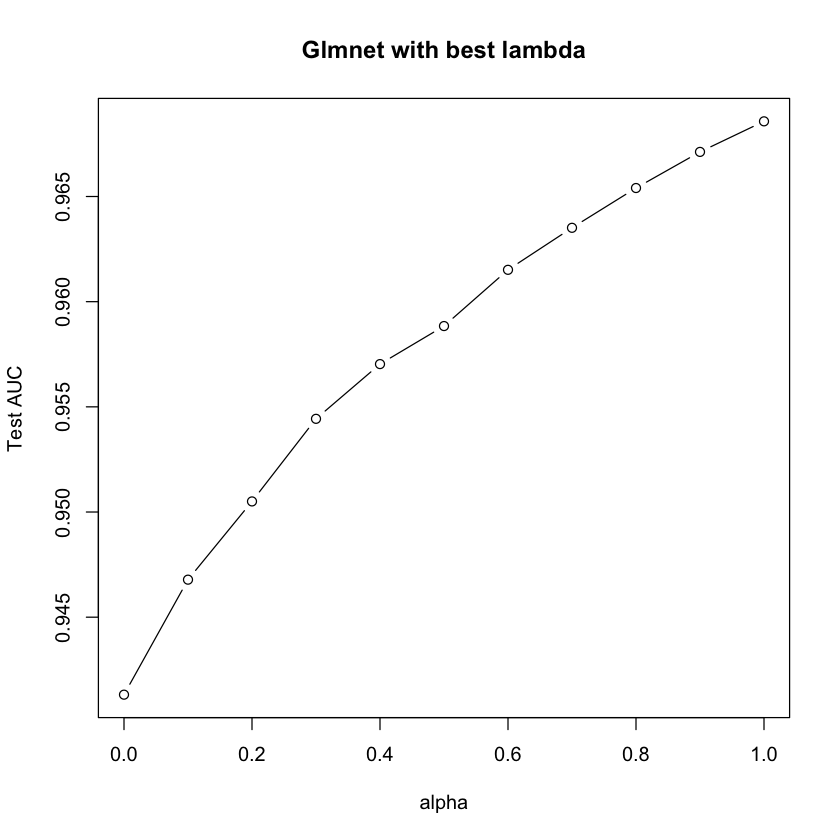

In [185]:
library(glmnet)
library(ROCR)
nlambda <- 10

alphalist <- seq(0,1,0.1)
auclist <- c()
firstalpha <- TRUE
for (alpha in alphalist) {
  # Train glmnet model
  m_glm <- glmnet(data_train$x, data_train$y, family="binomial", intercept=F, alpha=alpha, standardize = F, nlambda=nlambda)
  # Predict on the validation set
  ypred <- data_valid$x %*% m_glm$beta
  pred <- sapply(seq(ncol(ypred)), function(j) {prediction(ypred[,j], data_valid$y)})
  auc <- unlist(lapply(pred, function(p) {performance(p, "auc")@y.values[[1]]}))
  if (length(auc) < nlambda) { # glmnet did not converge for the last lambda values
    auc <- c(auc, rep(0.5, nlambda-length(auc)))
  }
  if (firstalpha) {
    auc_el <- auc
    firstalpha <- FALSE
  } else {
    auc_el <- cbind(auc_el, auc)
  }
  
  # Assess AUC of the best lambda on the test set
  bestlambdaindex <- which.max(auc)
  ypred <- data_test$x %*% m_glm$beta[,bestlambdaindex]
  auc <- performance(prediction(ypred, data_test$y), "auc")@y.values[[1]]
  auclist <- c(auclist,auc)
}
plot(alphalist, auclist[1:11], type='b', xlab='alpha', ylab='Test AUC', main='Glmnet with best lambda')

print(paste("at alpha=1 the accuracy is ",auclist[length(auclist)], "It is for the best lambda that is ", m_glm$lambda[bestlambdaindex]))


Warning message in plot.window(...):
“"legend" n'est pas un paramètre graphique”Warning message in plot.xy(xy, type, ...):
“"legend" n'est pas un paramètre graphique”Warning message in axis(side = side, at = at, labels = labels, ...):
“"legend" n'est pas un paramètre graphique”Warning message in axis(side = side, at = at, labels = labels, ...):
“"legend" n'est pas un paramètre graphique”Warning message in box(...):
“"legend" n'est pas un paramètre graphique”Warning message in title(...):
“"legend" n'est pas un paramètre graphique”

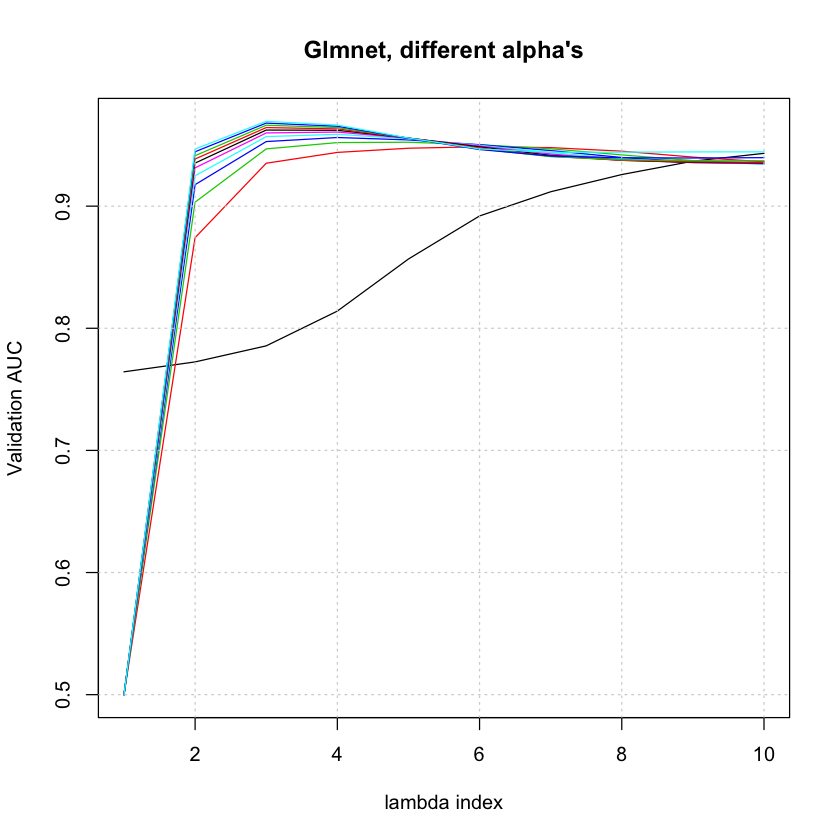

In [186]:
matplot(auc_el, type='l', lty=1, xlab='lambda index', ylab='Validation AUC', main="Glmnet, different alpha's", legend=alphalist)
grid()

One can notice that the ElasticNet is best performing when it is selecting variables, this can be explained by the presence of the completely noisy variables in this simulation setting.
Let's now see for the DropLasso 

[1] "at p=1 the accuracy is  0.967808379736304 . It is for the best lambda that is  0.00425365636986015"


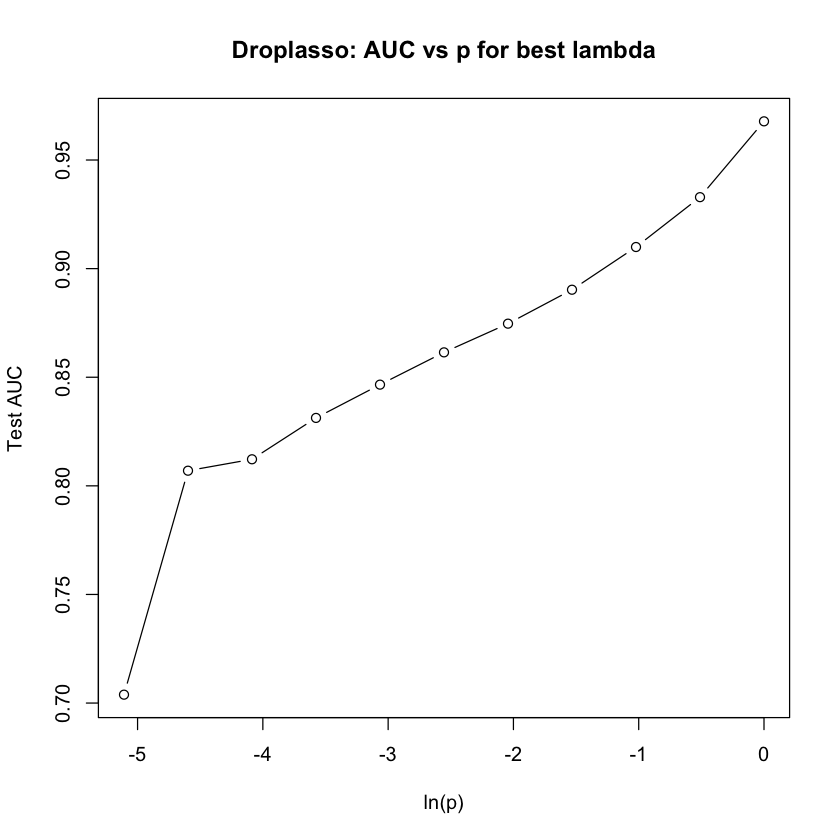

In [187]:
n_passes = 10000
probalist <- 0.6^seq(0,10)
library(droplasso)

auclist <- c()
for (proba in probalist) {
  # Train on the train set
  m <- droplasso(data_train$x, data_train$y, family="binomial", keep_prob=proba, nlambda=nlambda, n_passes = n_passes,decay=0.1)
  # Pick lambda with the best AUC on the validation set
  ypred <- predict(m, data_valid$x)
  pred <- sapply(seq(ncol(ypred)), function(j) {prediction(ypred[,j], data_valid$y)})
  auc <- unlist(lapply(pred, function(p) {performance(p, "auc")@y.values[[1]]}))
  bestlambda <- m$lambda[which.max(auc)]
  # Assess AUC of the best lambda on the test set
  ypred <- predict(m, data_test$x, s=bestlambda)
  auc <- performance(prediction(ypred, data_test$y), "auc")@y.values[[1]]
  auclist <- c(auclist,auc)
}
plot(log(probalist), auclist, type='b', xlab='ln(p)', ylab='Test AUC', main='Droplasso: AUC vs p for best lambda')

print(paste("at p=1 the accuracy is ",auclist[1], ". It is for the best lambda that is ", bestlambda))


We can see that for a data set without noise (what we simulated with q=1), DropLasso performs best without dropout. Let's test dropLasso now with noise '

[1] "at p=1 the accuracy is  0.568846575998816 . It is for the best lambda that is  2e-05"


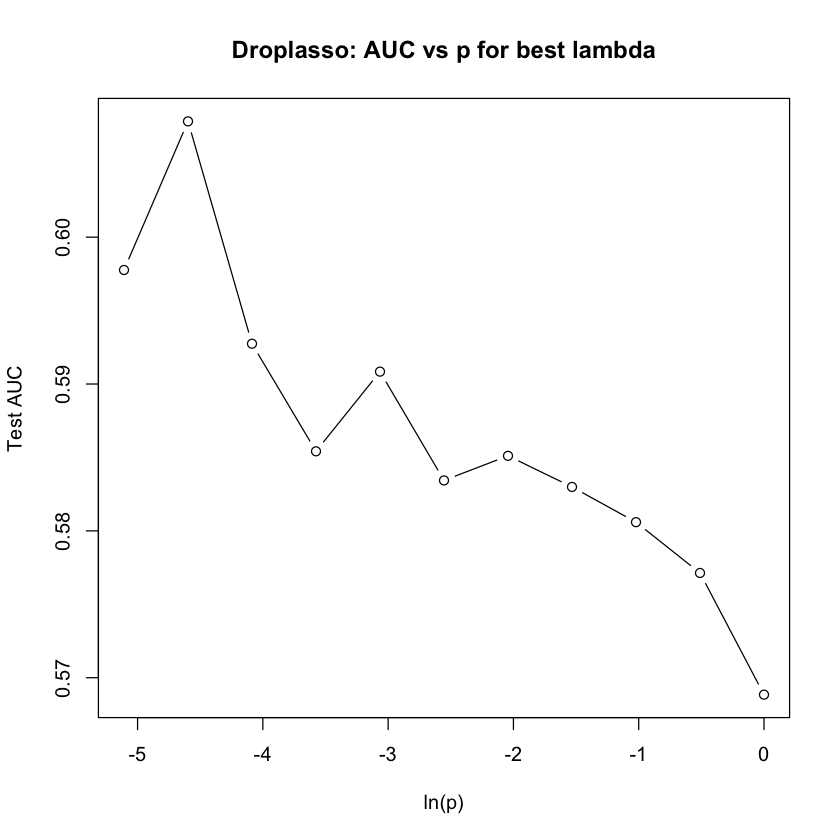

In [165]:
data_train <- generate_data(q=0.4)
data_valid <- generate_data(n=10000,q=0.4)
data_test <- generate_data(n=10000,q=0.4)

n_passes = 10000
probalist <- 0.6^seq(0,10)

auclist <- c()
for (proba in probalist) {
  # Train on the train set
  m <- droplasso(data_train$x, data_train$y, family="binomial", keep_prob=proba, nlambda=nlambda, n_passes = n_passes,decay=0.1)
  # Pick lambda with the best AUC on the validation set
  ypred <- predict(m, data_valid$x)
  pred <- sapply(seq(ncol(ypred)), function(j) {prediction(ypred[,j], data_valid$y)})
  auc <- unlist(lapply(pred, function(p) {performance(p, "auc")@y.values[[1]]}))
  bestlambda <- m$lambda[which.max(auc)]
  # Assess AUC of the best lambda on the test set
  ypred <- predict(m, data_test$x, s=bestlambda)
  auc <- performance(prediction(ypred, data_test$y), "auc")@y.values[[1]]
  auclist <- c(auclist,auc)
}
plot(log(probalist), auclist, type='b', xlab='ln(p)', ylab='Test AUC', main='Droplasso: AUC vs p for best lambda')

print(paste("at p=1 the accuracy is ",auclist[1], ". It is for the best lambda that is ", bestlambda))


We now procceed to a comparaison between DropLasso, dropout and ElasticNet on our Simulation.
In order to make a fair comparaison, we repeat the following on multiple runs (nruns) : 
- Generate a training, a validation and a test dataset from the simulation setting.
- Perform a grid search and select the best parameters for each method on the validation set.
- Evaluate and average the accuracy of each method using the best selected parameters.
See code [here](https://github.com/BeyremKh/Droplasso-experiments/blob/master/simulation/compare_simul.R)

In [2]:
#dependecies 
library(parallel)
ncores <- detectCores() -1 
source("compare_simul.R")


Warning message:
“package ‘glmnet’ was built under R version 3.4.4”Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



[1] "the best average AUC for Elasticnet is  0.976395785798698  with a standard deviation of  0.00272597940713256"
[1] "the best average AUC for DropLasso is  0.960152115542912  with a standard deviation of  0.00993794732804515"
[1] "the best average AUC for dropout is  0.960992662857407  with a standard deviation of  0.00728223372526149"
[1] "the p-value between DropLasso and ElasticNet is  0.00027370763681928"


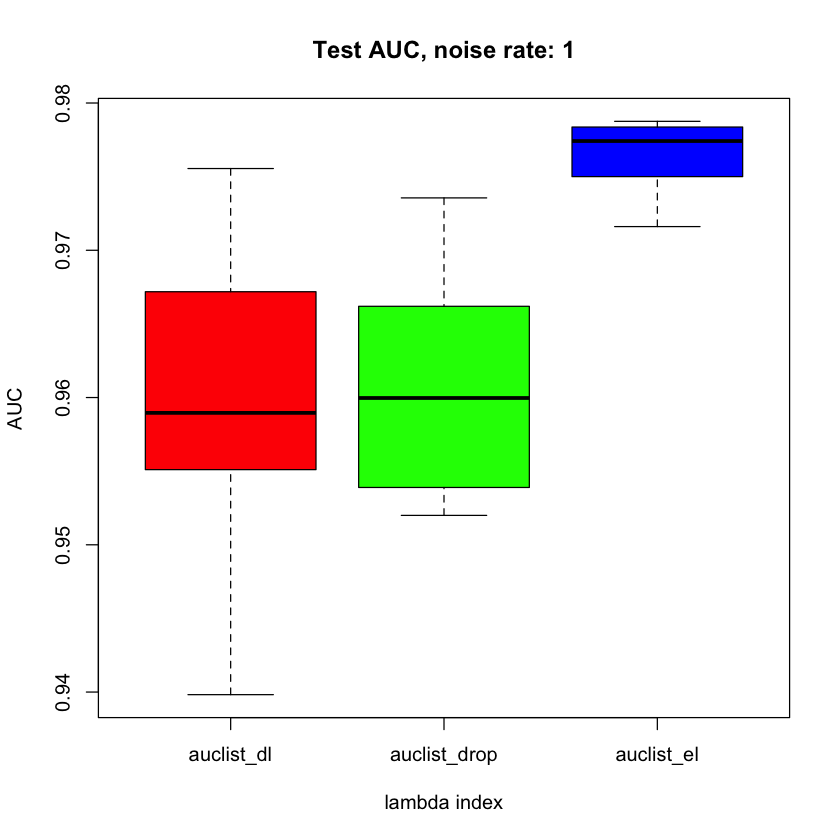

In [168]:
#10 runs accuracy comparaison with no noise
proc_compare(nruns=10, q=1)


[1] "the best average AUC for Elasticnet is  0.624696644663427  with a standard deviation of  0.0328400228345094"
[1] "the best average AUC for DropLasso is  0.631650258228621  with a standard deviation of  0.0165431537342466"
[1] "the best average AUC for dropout is  0.6337652779445  with a standard deviation of  0.0190839216754046"
[1] "the p-value between DropLasso and ElasticNet is  0.493122744987413"


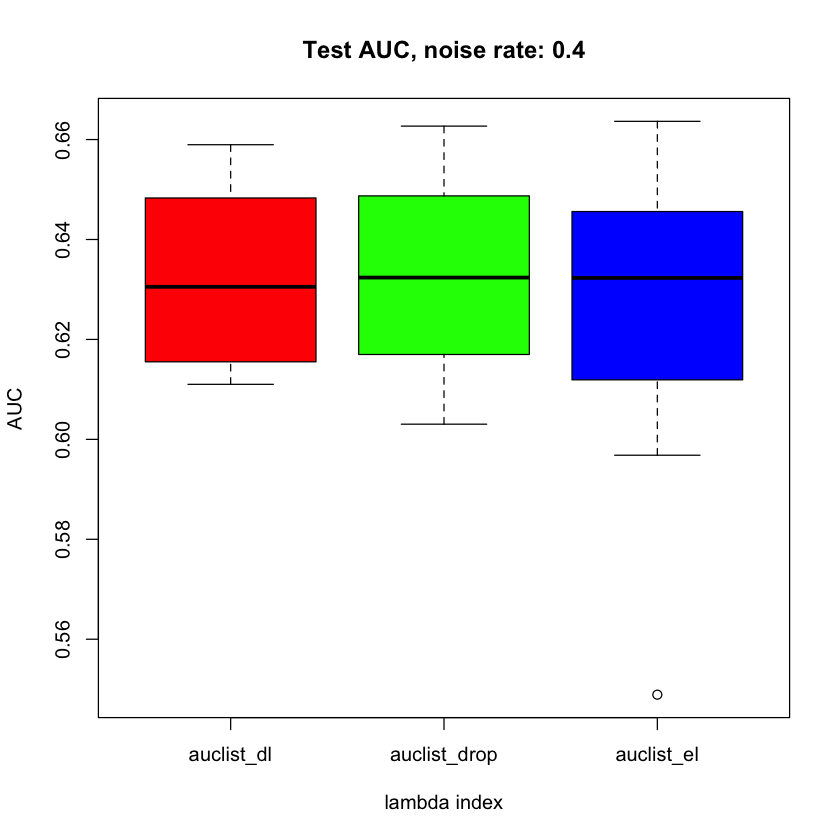

In [169]:
#10 runs accuracy comparaison with noise ration = 0.4

proc_compare(nruns=10, q=0.4)

[1] "the best average AUC for Elasticnet is  0.550196692020359  with a standard deviation of  0.0332343693377173"
[1] "the best average AUC for DropLasso is  0.565111862749949  with a standard deviation of  0.0204535763837831"
[1] "the best average AUC for dropout is  0.560396306571273  with a standard deviation of  0.0219892561387354"
[1] "the p-value between DropLasso and ElasticNet is  0.0656259213390129"


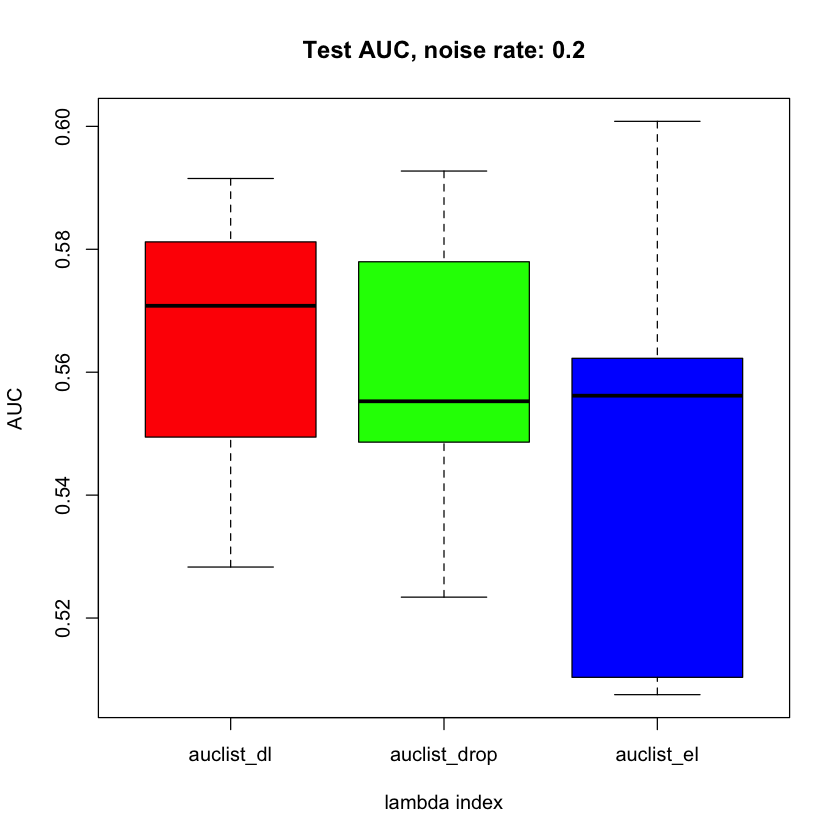

In [171]:
proc_compare(nruns=10, q=0.2)


We can see that ElasticNet outperforms droplasso when the simulations do not contain noise or do contain moderate noise. However droplasso significantly outperforms ElasticNet when the simulations contain more and more noise.
# References
